<a href="https://colab.research.google.com/github/Raoina/Spectra-2-Image/blob/main/notebooks/models/PLS/PLS_single_target.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ================== 0. Imports ==================
import numpy as np
import pandas as pd
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from scipy.signal import savgol_filter

In [ ]:
!ls /content

Moi_cv_pp_ps.png	    sample_data
Moi_pls_model_pp_ps.joblib  spectra_train_700.csv
Moi_test_pp_ps.png	    Starch_cv_pp_ps.png
Moi_training_pp_ps.png	    Starch_pls_model_pp_ps.joblib
NDF_cv_pp_ps.png	    Starch_test_pp_ps.png
NDF_pls_model_pp_ps.joblib  Starch_training_pp_ps.png
NDF_test_pp_ps.png	    target_train_700.csv
NDF_training_pp_ps.png


In [23]:
# ================== 1. Read Data ==================
# Features (spectra)
X = pd.read_csv("/content/spectra_train_488.csv").values

# Targets
y_df = pd.read_csv("/content/target_train_488.csv")

print("Columns in target_train_488.csv:")
display(y_df.columns)

Columns in target_train_488.csv:


Index(['Moi', 'NDF', 'Starch'], dtype='object')

In [24]:
# Select target column (change if needed: 'Moi', 'Starch', etc.)
target_column = 'Starch'
y = y_df[target_column].values.ravel()

# Split into train/test (instead of separate test file)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

print("\n✅ Data loaded and split:")
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")


✅ Data loaded and split:
Shape of X_train: (366, 257)
Shape of y_train: (366,)
Shape of X_test: (122, 257)
Shape of y_test: (122,)


In [4]:
# ================== 2. Preprocessing ==================
def transmission_to_absorbance(X):
    # Avoid division by zero or log of zero/negative numbers
    X = np.clip(X, 1e-10, None)
    return np.log10(1 / X)

def snv(X):
    X = np.asarray(X, dtype=float)
    mean = np.mean(X, axis=1, keepdims=True)
    std  = np.std(X, axis=1, keepdims=True)
    std[std == 0] = 1.0  # avoid division by zero
    return (X - mean) / std

def savgol_derivative(X, win=15, poly=3, deriv=2):
    n_cols = X.shape[1]
    if win % 2 == 0:  # window length must be odd
        win += 1
    if win > n_cols:  # adjust if window > features
        win = n_cols - 1 if (n_cols - 1) % 2 == 1 else n_cols - 2
        if win < 3:
            win = 3
    return savgol_filter(X, window_length=win, polyorder=poly, deriv=deriv, axis=1)

def mean_center(X, mean=None):
    if mean is None:
        mean = np.mean(X, axis=0)
    return X - mean, mean

def auto_scale(X, mean=None, std=None):
    if mean is None or std is None:
        mean = np.mean(X, axis=0)
        std = np.std(X, axis=0)
    # Check if std is a scalar (for 1D arrays like y)
    if np.isscalar(std):
        if std == 0:
            std = 1e-10
    else: # For multi-dimensional arrays like X
        std[std == 0] = 1e-10  # avoid division by zero
    return (X - mean) / std, mean, std

def inverse_auto_scale(X_scaled, mean, std):
    return (X_scaled * std) + mean


# Example preprocessing pipeline: Transmission->Absorbance + Savitzky-Golay (derivative=2) + Auto-scale
def preprocess_absorbance_sg_autoscale(X_train, X_test, y_train, y_test):
    # Step 1: Transmission to Absorbance
    X_train_abs = transmission_to_absorbance(X_train)
    X_test_abs  = transmission_to_absorbance(X_test)

    # Step 2: Savitzky-Golay (applied after Absorbance)
    X_train_sg = savgol_derivative(X_train_abs)
    X_test_sg  = savgol_derivative(X_test_abs)

    # Step 3: Auto-scale X
    X_train_proc, mean_x, std_x = auto_scale(X_train_sg)
    X_test_proc, _, _ = auto_scale(X_test_sg, mean_x, std_x) # Use train mean and std for test set

    # Step 4: Auto-scale y
    y_train_proc, mean_y, std_y = auto_scale(y_train)
    y_test_proc, _, _ = auto_scale(y_test, mean_y, std_y) # Use train mean and std for test set


    return X_train_proc, X_test_proc, y_train_proc, y_test_proc, mean_y, std_y

# Apply preprocessing
X_train_proc, X_test_proc, y_train_proc, y_test_proc, mean_y, std_y = preprocess_absorbance_sg_autoscale(
    X_train, X_test, y_train, y_test
)

print("\n✅ Data preprocessed:")
print(f"X_train_proc: {X_train_proc.shape}, X_test_proc: {X_test_proc.shape}")
print(f"y_train_proc: {y_train_proc.shape}, y_test_proc: {y_test_proc.shape}")
print(f"mean_y: {mean_y}, std_y: {std_y}")


✅ Data preprocessed:
X_train_proc: (366, 257), X_test_proc: (122, 257)
y_train_proc: (366,), y_test_proc: (122,)
mean_y: 63.60701149969945, std_y: 6.1531170059191975


In [25]:
# ================== 2. Preprocessing (without SNV) ==================
def transmission_to_absorbance(X):
    # Avoid division by zero or log of zero/negative numbers
    X = np.clip(X, 1e-10, None)
    return np.log10(1 / X)

def savgol_derivative(X, win=9, poly=7, deriv=1):
    n_cols = X.shape[1]
    if win % 2 == 0:  # window length must be odd
        win += 1
    if win > n_cols:  # adjust if window > features
        win = n_cols - 1 if (n_cols - 1) % 2 == 1 else n_cols - 2
        if win < 3:
            win = 3
    return savgol_filter(X, window_length=win, polyorder=poly, deriv=deriv, axis=1)

def mean_center(X, mean=None):
    if mean is None:
        mean = np.mean(X, axis=0)
    return X - mean, mean

def auto_scale(X, mean=None, std=None):
    if mean is None or std is None:
        mean = np.mean(X, axis=0)
        std = np.std(X, axis=0)
    # Check if std is a scalar (for 1D arrays like y)
    if np.isscalar(std):
        if std == 0:
            std = 1e-10
    else: # For multi-dimensional arrays like X
        std[std == 0] = 1e-10  # avoid division by zero
    return (X - mean) / std, mean, std

def inverse_auto_scale(X_scaled, mean, std):
    return (X_scaled * std) + mean


# Modified preprocessing pipeline: Transmission->Absorbance + Savitzky-Golay (derivative=2) + Auto-scale (without SNV)
def preprocess_absorbance_sg_autoscale_no_snv(X_train, X_test, y_train, y_test):
    # Step 1: Transmission to Absorbance
    X_train_abs = transmission_to_absorbance(X_train)
    X_test_abs  = transmission_to_absorbance(X_test)

    # Step 2: Savitzky-Golay (applied after Absorbance)
    X_train_sg = savgol_derivative(X_train_abs)
    X_test_sg  = savgol_derivative(X_test_abs)

    # Step 3: Auto-scale X
    X_train_proc_no_snv, mean_x_no_snv, std_x_no_snv = auto_scale(X_train_sg)
    X_test_proc_no_snv, _, _ = auto_scale(X_test_sg, mean_x_no_snv, std_x_no_snv) # Use train mean and std for test set

    # Step 4: Auto-scale y
    y_train_proc_no_snv, mean_y_no_snv, std_y_no_snv = auto_scale(y_train)
    y_test_proc_no_snv, _, _ = auto_scale(y_test, mean_y_no_snv, std_y_no_snv) # Use train mean and std for test set


    return X_train_proc_no_snv, X_test_proc_no_snv, y_train_proc_no_snv, y_test_proc_no_snv, mean_y_no_snv, std_y_no_snv

# Apply preprocessing without SNV
X_train_proc_no_snv, X_test_proc_no_snv, y_train_proc_no_snv, y_test_proc_no_snv, mean_y_no_snv, std_y_no_snv = preprocess_absorbance_sg_autoscale_no_snv(
    X_train, X_test, y_train, y_test
)

print("\n✅ Data preprocessed without SNV:")
print(f"X_train_proc_no_snv: {X_train_proc_no_snv.shape}, X_test_proc_no_snv: {X_test_proc_no_snv.shape}")
print(f"y_train_proc_no_snv: {y_train_proc_no_snv.shape}, y_test_proc_no_snv: {y_test_proc_no_snv.shape}")
print(f"mean_y_no_snv: {mean_y_no_snv}, std_y_no_snv: {std_y_no_snv}")


✅ Data preprocessed without SNV:
X_train_proc_no_snv: (366, 257), X_test_proc_no_snv: (122, 257)
y_train_proc_no_snv: (366,), y_test_proc_no_snv: (122,)
mean_y_no_snv: 33.049508196721305, std_y_no_snv: 8.29363270672005


In [26]:
# ================== 2.5 Save Combined Preprocessed Data ==================
import os
import pandas as pd
import numpy as np

# Create folder to save preprocessed data
save_dir = "/content/preprocessed_data"
os.makedirs(save_dir, exist_ok=True)

# Combine train + test
spectra_488_proc3 = np.vstack([X_train_proc, X_test_proc])
target_488_proc = np.concatenate([y_train_proc, y_test_proc])

# Save combined X
np.savetxt(f"{save_dir}/spectra_488_proc3.csv", spectra_488_proc3, delimiter=",")

# Save combined y with column name
y_df = pd.DataFrame(target_488_proc, columns=[target_column])
y_df.to_csv(f"{save_dir}/{target_column}_488_proc.csv", index=False)

print("\n✅ Combined preprocessed data saved successfully:")
print(f"spectra_488_proc3 shape: {spectra_488_proc3.shape}")
print(f"target_488_proc shape: {target_488_proc.shape}")
print(f"Saved in: {save_dir}")


✅ Combined preprocessed data saved successfully:
spectra_488_proc3 shape: (488, 257)
target_488_proc shape: (488,)
Saved in: /content/preprocessed_data


In [28]:
# ====================== display dataset preprocessed ============
display(pd.DataFrame(spectra_488_proc3))
display(pd.DataFrame(target_488_proc))

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
0,0.683446,0.743745,0.812551,0.890932,0.979594,1.078283,1.184725,1.293104,1.374405,1.457818,...,1.584570,1.756291,1.909282,2.066201,2.218810,2.154388,1.555908,0.782672,0.241677,-0.092247
1,0.620834,0.632256,0.643992,0.655502,0.665793,0.673153,0.674815,0.666712,0.632455,0.546706,...,1.194651,1.091059,1.017592,0.930887,0.738442,0.325304,-0.259576,-0.676630,-0.878297,-0.974019
2,-0.018568,-0.045466,-0.076915,-0.113824,-0.157164,-0.207792,-0.266054,-0.331082,-0.386222,-0.418997,...,-0.711052,-0.855990,-1.002866,-1.283363,-1.681882,-2.088525,-2.083372,-1.682970,-1.298028,-1.026990
3,0.898874,0.951267,1.010245,1.076276,1.149275,1.227987,1.308986,1.385378,1.452243,1.516613,...,0.027911,0.192001,0.368030,0.627900,1.026383,1.524603,1.767694,1.625307,1.404196,1.228954
4,-0.569949,-0.497711,-0.411617,-0.308286,-0.183689,-0.033430,0.146372,0.357128,0.594108,0.896776,...,-1.451412,-1.406608,-1.357575,-1.276687,-1.075855,-0.602042,0.123947,0.679331,0.966076,1.110576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483,-0.117669,-0.206780,-0.310817,-0.432708,-0.575544,-0.741969,-0.932866,-1.145023,-1.310855,-1.512927,...,-0.428118,-0.538747,-0.644952,-0.862355,-1.178136,-1.521962,-1.576427,-1.319998,-1.053607,-0.861428
484,-1.788555,-1.883481,-1.989918,-2.108468,-2.238613,-2.377537,-2.518272,-2.647361,-2.652487,-2.561504,...,-2.925032,-3.001664,-3.042325,-3.030323,-2.852321,-2.166931,-0.804226,0.435479,1.164196,1.569753
485,1.384392,1.430277,1.480352,1.534125,1.590152,1.645313,1.693766,1.725872,1.746276,1.706971,...,0.149279,0.203452,0.237286,0.238055,0.226911,0.177244,0.073620,-0.023021,-0.080725,-0.113179
486,-0.078275,-0.128610,-0.187346,-0.256118,-0.336644,-0.430379,-0.537765,-0.656916,-0.782107,-0.962758,...,-0.296599,-0.434503,-0.515733,-0.564729,-0.616573,-0.613869,-0.462525,-0.253851,-0.104356,-0.010965


,0
0,2.644835
1,0.629470
2,-0.737944
3,0.827470
4,1.858872
...,...
483,-0.663789
484,-2.676467
485,0.376986
486,-0.991342


In [29]:
import shutil
from google.colab import files

# Define the path to the directory you want to zip
directory_path = '/content/preprocessed_data'

# Define the name for the zip file
zip_file_name = 'preprocessed_data.zip'
zip_file_path = f'/content/{zip_file_name}'

# Create a zip archive of the directory
shutil.make_archive(zip_file_path.replace('.zip', ''), 'zip', directory_path)

print(f"Directory '{directory_path}' has been zipped to '{zip_file_path}'")

# Provide a download link for the zip file
files.download(zip_file_path)

Directory '/content/preprocessed_data' has been zipped to '/content/preprocessed_data.zip'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ================== 3. Metrics ==================
def metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    bias = np.mean(y_pred - y_true)
    return r2, rmse, bias

def coefficient_of_variation(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mean_y_true = np.mean(y_true)
    return np.nan if mean_y_true == 0 else (rmse / mean_y_true) * 100

In [ ]:
# ================== 4. Optimize PLS LV ==================
def optimize_pls(X_train, y_train, max_lv=10):
    best_lv, best_r2 = 1, -np.inf
    best_y_cv = None
    for lv in range(1, max_lv+1):
        pls = PLSRegression(n_components=lv)
        y_cv = cross_val_predict(pls, X_train, y_train, cv=5).ravel()
        r2 = r2_score(y_train, y_cv)
        if r2 > best_r2:
            best_r2, best_lv = r2, lv
            best_y_cv = y_cv
    return best_lv, best_y_cv

In [ ]:
# ================== 5. Train Final Model ==================
best_lv, y_cv = optimize_pls(X_train_proc, y_train_proc, max_lv=10)
print(f"\n✅ Best LV from CV: {best_lv}")


✅ Best LV from CV: 4


In [ ]:
pls = PLSRegression(n_components=8)
pls.fit(X_train_proc, y_train_proc)

y_pred_train = pls.predict(X_train_proc).ravel()
y_pred_test  = pls.predict(X_test_proc).ravel()

In [ ]:
# ================== 6. Results ==================

# Inverse transform predictions to original scale (needed for plotting later)
y_pred_train_orig = inverse_auto_scale(y_pred_train, mean_y, std_y)
y_pred_test_orig  = inverse_auto_scale(y_pred_test, mean_y, std_y)
y_cv_orig = inverse_auto_scale(y_cv, mean_y, std_y)


print("\n--- Training (original scale) ---")
train_r2, train_rmse, train_bias = metrics(y_train, y_pred_train_orig)
print(f"R2: {train_r2:.4f}, RMSE: {train_rmse:.4f}, Bias: {train_bias:.4f}")

print("\n--- CV (original scale) ---")
cv_r2, cv_rmse, cv_bias = metrics(y_train, y_cv_orig)
print(f"R2: {cv_r2:.4f}, RMSE: {cv_rmse:.4f}, Bias: {cv_bias:.4f}")

print("\n--- Test (original scale) ---")
test_r2, test_rmse, test_bias = metrics(y_test, y_pred_test_orig)
print(f"R2: {test_r2:.4f}, RMSE: {test_rmse:.4f}, Bias: {test_bias:.4f}")



--- Training (original scale) ---
R2: 0.8631, RMSE: 2.2764, Bias: 0.0000

--- CV (original scale) ---
R2: 0.8216, RMSE: 2.5989, Bias: -0.0212

--- Test (original scale) ---
R2: 0.8692, RMSE: 2.2629, Bias: -0.3340


Plot saved to Moi_training_pls_488.png


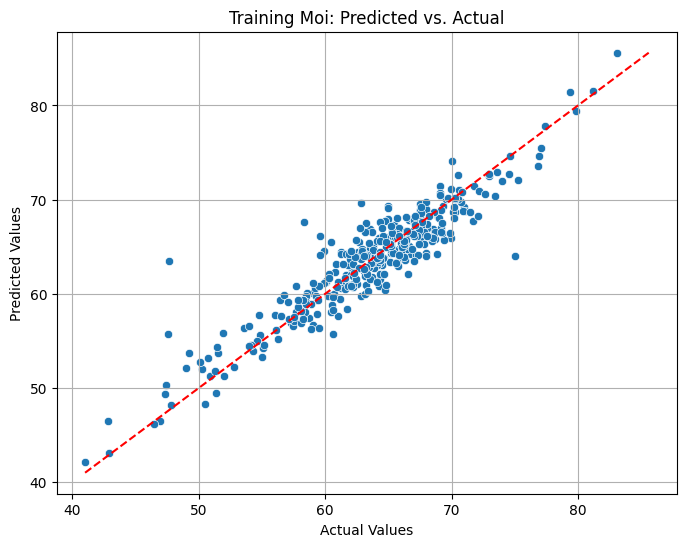

Plot saved to Moi_cv_pls_488.png


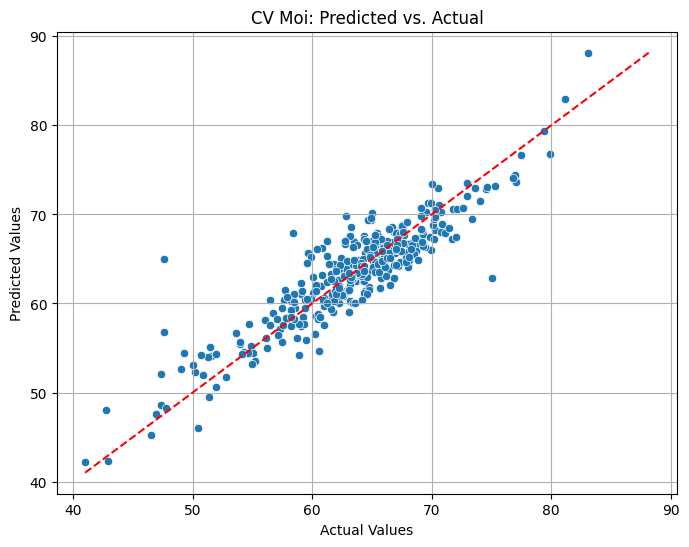

Plot saved to Moi_test_pls_488.png


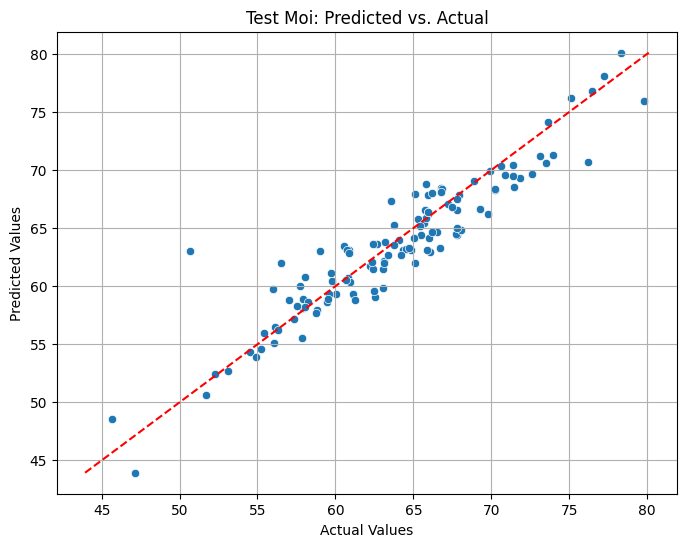

In [ ]:
# ================== 7. Visualization (Predicted vs. Actual) ==================
import matplotlib.pyplot as plt
import seaborn as sns

def plot_pls_488(y_true, y_pred, title, save_path=None):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_true, y=y_pred)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(title)
    # Add y=x line for reference
    max_val = max(max(y_true), max(y_pred))
    min_val = min(min(y_true), min(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')
    plt.grid(True)
    if save_path:
        plt.savefig(save_path)
        print(f"Plot saved to {save_path}")
    plt.show()

# Plot for Training set
plot_pls_488(y_train, y_pred_train_orig, f"Training {target_column}: Predicted vs. Actual", save_path=f"{target_column}_training_pls_488.png")

# Plot for Cross-Validation set
plot_pls_488(y_train, y_cv_orig, f"CV {target_column}: Predicted vs. Actual", save_path=f"{target_column}_cv_pls_488.png")


# Plot for Test set
plot_pls_488(y_test, y_pred_test_orig, f"Test {target_column}: Predicted vs. Actual", save_path=f"{target_column}_test_pls_488.png")

In [ ]:
# ================== 8. Save Model ==================
import joblib

model_filename = f"{target_column}_pls_model_pls_488.joblib"
joblib.dump(pls, model_filename)
print(f"\n✅ Model saved as: {model_filename}")


✅ Model saved as: Moi_pls_model_pls_488.joblib


In [ ]:
import os
import zipfile

def zip_specific_files(file_paths, zip_path):
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for file_path in file_paths:
            if os.path.exists(file_path):
                arcname = os.path.basename(file_path)
                zipf.write(file_path, arcname)
            else:
                print(f"Warning: File not found - {file_path}")

# List of files to zip
files_to_zip = [
    '/content/Moi_cv_pls_488.png',
    '/content/Moi_pls_model_pls_488.joblib',
    '/content/Moi_test_pls_488.png',
    '/content/Moi_training_pls_488.png',
    '/content/NDF_cv_pls_488.png',
    '/content/NDF_pls_model_pls_488.joblib',
    '/content/NDF_test_pls_488.png',
    '/content/NDF_training_pls_488.png',
    '/content/Starch_cv_pls_488.png',
    '/content/Starch_pls_model_pls_488.joblib',
    '/content/Starch_test_pls_488.png',
    '/content/Starch_training_pls_488.png',
]

# Define the name and path of the zip file
zip_file_name = 'selected_files.zip'
zip_file_path = os.path.join('/content', zip_file_name)

# Create the zip file
zip_specific_files(files_to_zip, zip_file_path)

print(f"Selected files have been zipped to {zip_file_path}")

Selected files have been zipped to /content/selected_files.zip
